Medical Image Classification Tutorial with the MedNIST Dataset

Setup environment

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 70.2 MB/s eta 0:00:00


Setup imports

In [6]:
pip install numpy

In [7]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.5.dev2511
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7876647f87c763d854f9546bbc60e12f13af84a6
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.14.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.49.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io

Setup data directory
You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [8]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmplm4ajn4b


Download dataset
The MedNIST dataset was gathered from several sets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset.

The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

If you use the MedNIST dataset, please acknowledge the source.

In [5]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:03, 16.9MB/s]                            

2025-03-21 01:07:51,424 - INFO - Downloaded: /tmp/tmp4pvukij1/MedNIST.tar.gz


2025-03-21 01:07:51,557 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-03-21 01:07:51,558 - INFO - Writing into directory: /tmp/tmp4pvukij1.


Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

Read image filenames from the dataset folders
First of all, check the dataset files and show some statistics.
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,
which should be used as the labels to train our classification model.

In [7]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


Randomly pick images from the dataset to visualize and check

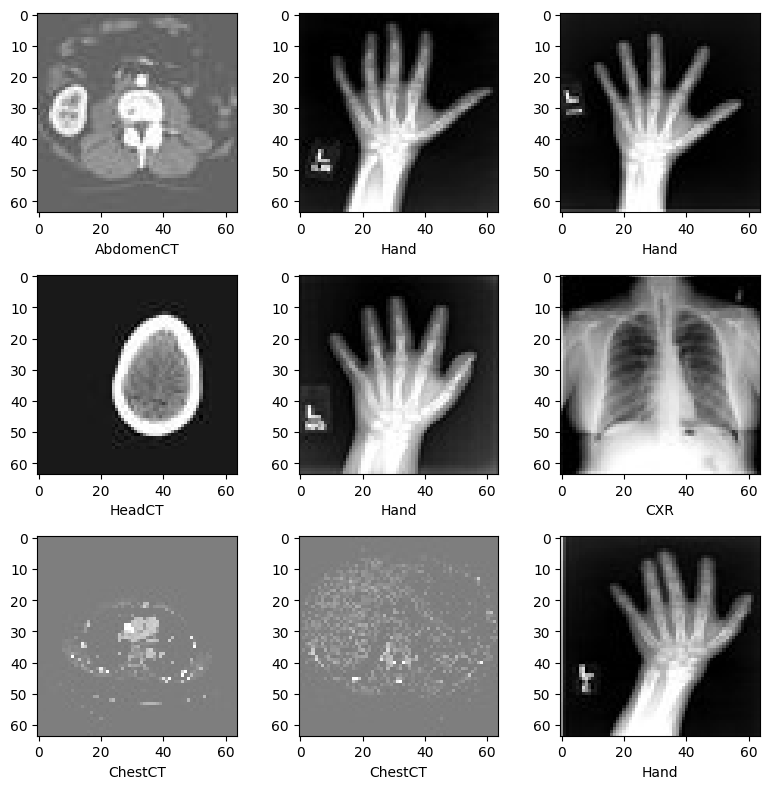

In [8]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

Prepare training, validation and test data lists
Randomly select 10% of the dataset as validation and 10% as test.

In [9]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


Define MONAI transforms, Dataset and Dataloader to pre-process data

In [10]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [11]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Define network and optimizer
Set learning rate for how much the model is updated per batch.
Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
And as this is just a get start tutorial, let's just train 4 epochs.
If train 10 epochs, the model can achieve 100% accuracy on test dataset.
Use DenseNet from MONAI and move to GPU device, this DenseNet can support both 2D and 3D classification tasks.
Use Adam optimizer.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

Model training
Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.
Will save the model weights to file if got best validation accuracy.

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/4
1/157, train_loss: 1.7984
2/157, train_loss: 1.7464
3/157, train_loss: 1.7419
4/157, train_loss: 1.7237
5/157, train_loss: 1.6872
6/157, train_loss: 1.6540
7/157, train_loss: 1.6107
8/157, train_loss: 1.5920
9/157, train_loss: 1.5809
10/157, train_loss: 1.5624
11/157, train_loss: 1.5339
12/157, train_loss: 1.5089
13/157, train_loss: 1.4880
14/157, train_loss: 1.4602
15/157, train_loss: 1.4458
16/157, train_loss: 1.4372
17/157, train_loss: 1.4179
18/157, train_loss: 1.3882
19/157, train_loss: 1.3413
20/157, train_loss: 1.3568
21/157, train_loss: 1.3113
22/157, train_loss: 1.3033
23/157, train_loss: 1.2816
24/157, train_loss: 1.2565
25/157, train_loss: 1.2713
26/157, train_loss: 1.2415
27/157, train_loss: 1.2065
28/157, train_loss: 1.1955
29/157, train_loss: 1.1637
30/157, train_loss: 1.1580
31/157, train_loss: 1.1319
32/157, train_loss: 1.1263
33/157, train_loss: 1.1185
34/157, train_loss: 1.0914
35/157, train_loss: 1.0865
36/157, train_loss: 1.0739
37/157, train_lo

Plot the loss and metric

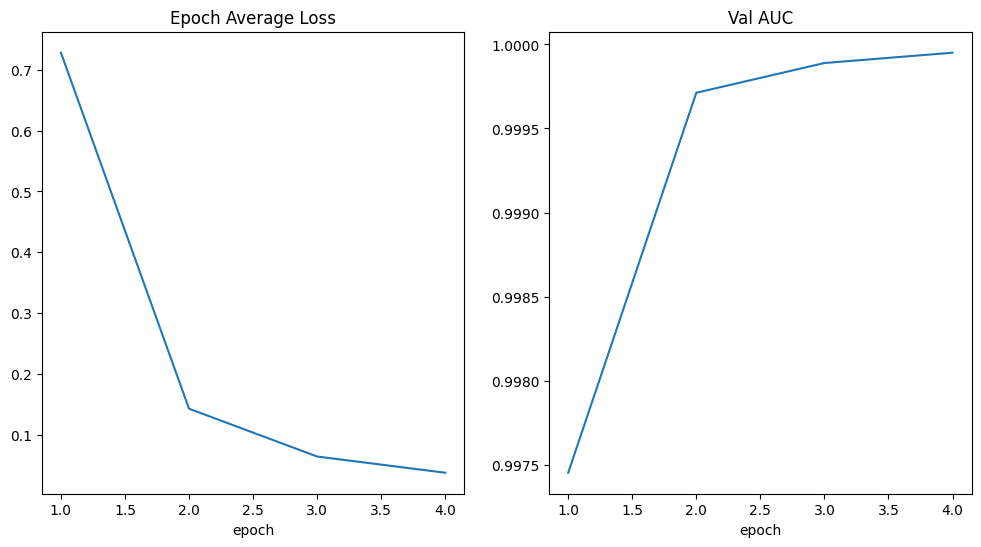

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

Evaluate the model on test dataset
After training and validation, we already got the best model on validation test.
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.
We'll use these predictions to generate a classification report.

In [15]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [16]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9920    0.9950    0.9935       995
   BreastMRI     0.9989    0.9886    0.9937       880
         CXR     0.9980    1.0000    0.9990       982
     ChestCT     0.9922    1.0000    0.9961      1014
        Hand     1.0000    0.9952    0.9976      1048
      HeadCT     0.9959    0.9969    0.9964       976

    accuracy                         0.9961      5895
   macro avg     0.9961    0.9960    0.9960      5895
weighted avg     0.9961    0.9961    0.9961      5895



Cleanup data directory
Remove directory if a temporary was used.

In [17]:
if directory is None:
    shutil.rmtree(root_dir)

Cloning into 'monai-classification'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (4/4), 1.31 KiB | 1.31 MiB/s, done.


Save model for hugging face deployment

In [9]:
import os
import torch
import monai

# Define model architecture (ensure it matches your trained model)
model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=1, out_channels=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Root directory: {root_dir}")

# Load trained model weights
# Assuming the model was saved in the 'root_dir' directory
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), map_location=device))
model.eval()

# Convert to TorchScript for deployment (Optional but recommended)
example_input = torch.randn(1, 1, 128, 128) # Adjust input size if needed
traced_model = torch.jit.trace(model, example_input.to(device))
traced_model.save("model_scripted.pt") # Save for inference

Root directory: /tmp/tmplm4ajn4b


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmplm4ajn4b/best_metric_model.pth'